# Generalized Linear Models
## Poisson Regression

All three **Generalized Linear Models (GLM)** currently available in scikit-learn have been integrated for FHE in Concrete ML: PoissonRegressor, GammaRegressor and TweedieRegressor. Choosing the best GLM directly depends on the initial problem one has to solve, and more specifically, how the target values are distributed.  Detailed information about those models can be found in their associated [documentation](https://scikit-learn.org/stable/modules/classes.html#:~:text=Generalized%20linear%20models%20(GLM)) as well as their [user guide](https://scikit-learn.org/stable/modules/linear_model.html#:~:text=vs%20other%20solvers%E2%80%9D-,1.1.12.%20Generalized%20Linear%20Regression).

This tutorial shows how to train **PoissonRegressor** and then run it in FHE using Concrete ML. We make use of quantization as FHE computations must be only be done on integers and show how this process does not degrade its performances.

A more general comparison of all three models is available in the [GLM comparison notebook](GLMComparison.ipynb).

### Import libraries

We import scikit-learn libraries, Concrete quantization tools as well as the Poisson regression model from both scikit-learn and Concrete ML:

In [1]:
import time

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import PoissonRegressor as SklearnPoissonRegressor
from sklearn.metrics import mean_poisson_deviance
from sklearn.model_selection import train_test_split

from concrete.ml.sklearn import PoissonRegressor as ConcretePoissonRegressor

And, finally, we import some helpers for visualization:

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

### Insurance claims data-set

A Poisson regression is adapted for modeling count data as well as relative frequencies (by scaling the values). It therefore expects that the target values are non-negative and assumes that they follow a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution).

Thus, let's build a regression model that predicts the frequency of incidents in an insurance setting.

We first download a [data-set](https://www.openml.org/d/41214) from OpenML that contains 670,000 examples giving the frequency of car accidents for drivers of various ages, past accident history, car type, car color, geographical region, etc. We only consider the first 50,000 examples in order to speed up the training part.


In [3]:
df, _ = fetch_openml(
    data_id=41214, as_frame=True, cache=True, data_home="~/.cache/sklearn", return_X_y=True
)
df = df.head(50000)

The target variable is the number of claims per year, which is computed by the following formula :

In [4]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

Let's visualize our data-set, showing that the target variable "Frequency" has a Poisson distribution.

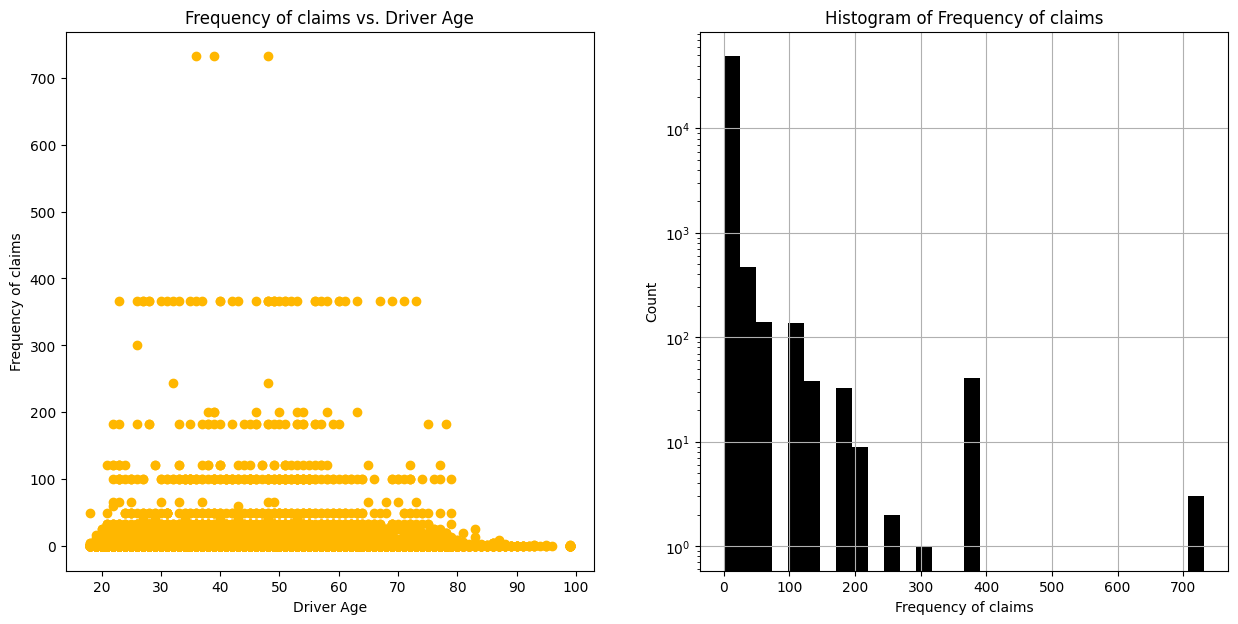

In [5]:
plt.ioff()
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
fig.patch.set_facecolor("white")
ax[0].set_title("Frequency of claims vs. Driver Age")
ax[0].set_xlabel("Driver Age")
ax[0].set_ylabel("Frequency of claims")
ax[0].scatter(df["DrivAge"], df["Frequency"], marker="o", color="#ffb700")
ax[1].set_title("Histogram of Frequency of claims")
ax[1].set_xlabel("Frequency of claims")
ax[1].set_ylabel("Count")
df["Frequency"].hist(bins=30, log=True, ax=ax[1], color="black")
display(fig)

We then split the data into a training and test set.

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

## Simple single variable insurance incident frequency predictor

Our first example only considers a single predictor feature. It is therefore easy to visualize the results. 

Let's extract our train and test data:

In [7]:
train_data = df_train["DrivAge"].values.reshape(-1, 1)
test_data = np.sort(df_test["DrivAge"].values).reshape(-1, 1)

We first train the scikit-learn PoissonRegressor model:

In [8]:
sklearn_pr = SklearnPoissonRegressor(max_iter=300)
sklearn_pr.fit(train_data, df_train["Frequency"], sample_weight=df_train["Exposure"]);

We can now test this predictor on the test data:

In [9]:
sklearn_predictions = sklearn_pr.predict(test_data)

Now, let's visualize our predictions to see how our model performs.

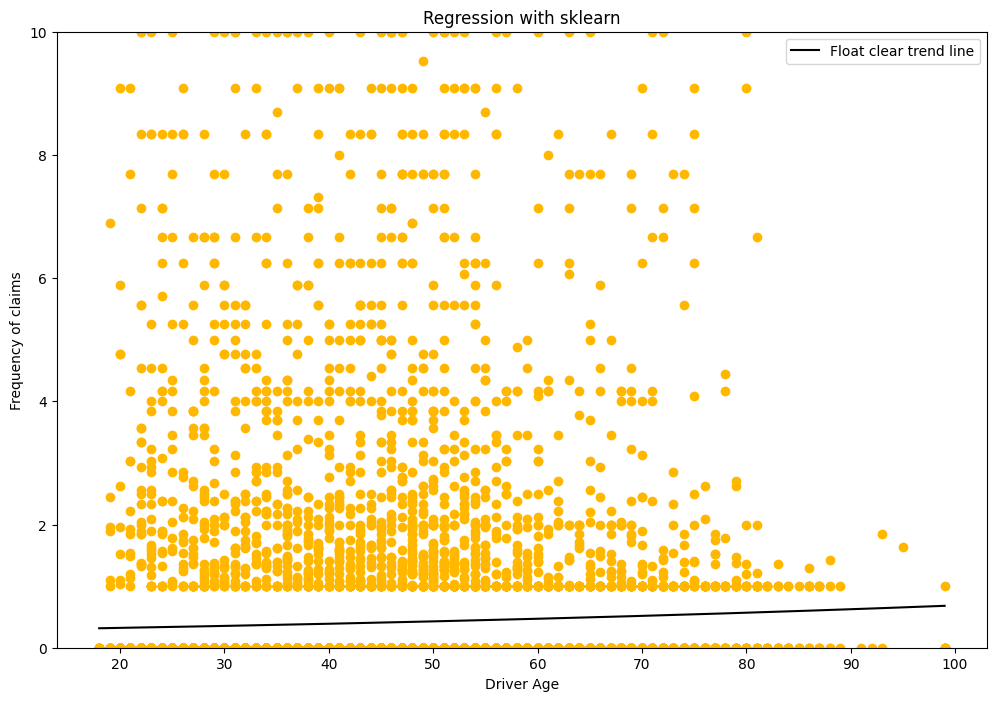

In [10]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.plot(test_data, sklearn_predictions, color="black", label="Float clear trend line")
ax.scatter(df_test["DrivAge"], df_test["Frequency"], marker="o", color="#ffb700")
ax.set_xlabel("Driver Age")
ax.set_ylim(0, 10)
ax.set_title("Regression with sklearn")
ax.set_ylabel("Frequency of claims")
ax.legend(loc="upper right")
display(fig)

### Analysis

We will now convert it to FHE in order to visually compare some details about quantization. A multivariate model will then be considered afterwards.

### Let's visualize the performance of a **quantized Poisson regressor**

First, we train the concrete PoissonRegressor model that will quantize the inputs and weights using 8 bits:

In [11]:
concrete_pr = ConcretePoissonRegressor(n_bits=8)
concrete_pr.fit(train_data, df_train["Frequency"], sample_weight=df_train["Exposure"])

PoissonRegressor()

We can now test this predictor on the test data the same way we did with scikit-learn:

In [12]:
concrete_predictions = concrete_pr.predict(test_data)

Finally, let's compare the Concrete quantized model's results with the scikit-learn one by measuring their goodness of fit on the test data using the Poisson deviance.

In [13]:
y_true = df_test["Frequency"]
sample_weight = df_test["Exposure"]

sklearn_score = mean_poisson_deviance(y_true, sklearn_predictions, sample_weight=sample_weight)
concrete_score = mean_poisson_deviance(y_true, concrete_predictions, sample_weight=sample_weight)

print(f"mean Poisson deviance (scikit-learn): {sklearn_score:.4f}")
print(f"mean Poisson deviance (Concrete ML): {concrete_score:.4f}")

mean Poisson deviance (scikit-learn): 1.6743
mean Poisson deviance (Concrete ML): 1.6743


We can observe that the deviances are identical (with an order of magnitude of about 1e-4). 
 
We then plot the two trend lines (scikit-learn float clear model and Concrete ML quantized clear model) to visualize this similarity. 

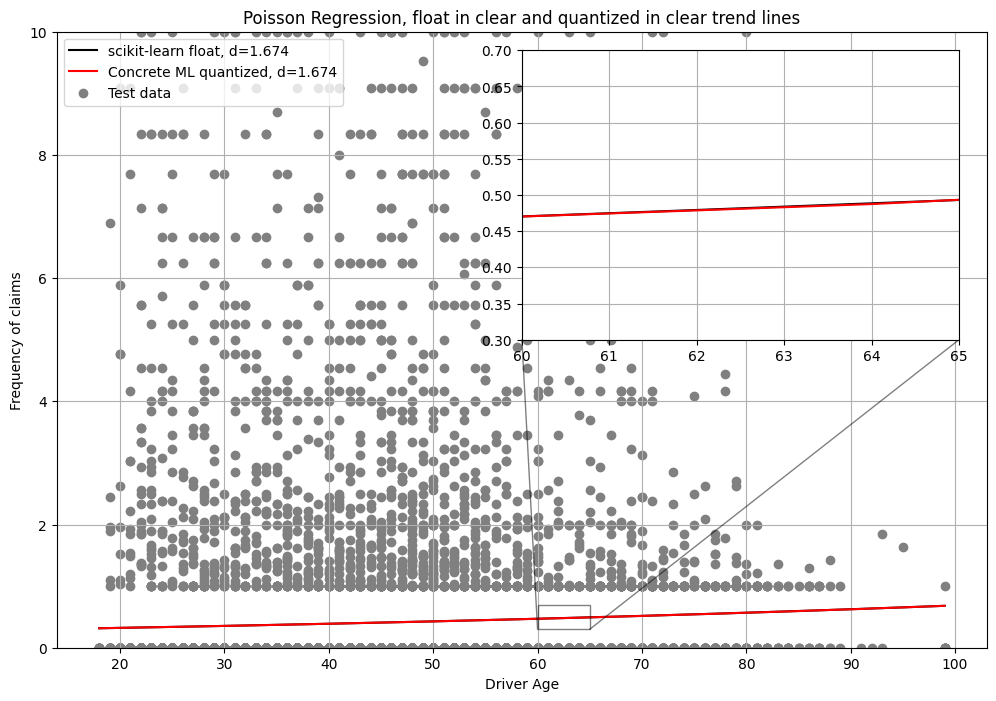

In [14]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")

# Plot the scikit-learn in clear model's main trend line
ax.plot(
    test_data,
    sklearn_predictions,
    color="black",
    label=f"scikit-learn float, d={sklearn_score:.3f}",
)

# Plot the Concrete quantized in clear model's main trend line
ax.plot(
    test_data,
    concrete_predictions,
    color="red",
    label=f"Concrete ML quantized, d={concrete_score:.3f}",
)

# Plot the test data
ax.scatter(df_test["DrivAge"], df_test["Frequency"], marker="o", color="gray", label="Test data")

# Parametrize the main figure
ax.set_xlabel("Driver Age")
ax.set_ylim(0, 10)
ax.set_title("Poisson Regression, float in clear and quantized in clear trend lines")
ax.set_ylabel("Frequency of claims")
ax.legend(loc="upper left")
ax.grid()


# Set a zoomed-in figure
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])

# Plot the scikit-learn in clear model's zoomed trend line
axins.plot(
    test_data,
    sklearn_predictions,
    color="black",
)

# Plot the Concrete quantized in clear model's zoomed trend line
axins.plot(
    test_data,
    concrete_predictions,
    color="red",
)

# Parametrize the zoomed figure
x1, x2, y1, y2 = 60, 65, 0.3, 0.7
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid()
ax.indicate_inset_zoom(axins, edgecolor="black")

display(fig)

### Analysis

In the graph above, the two trend lines seem to match perfectly. The quantization process thus seem to have a very negligible impact.

### Now it's time to make the inference homomorphic. 

Compiling a model to FHE is done with a single line of code. Providing some data to the compile method is necessary because it will help the model evaluate the maximum bit size of integers actually needed during the FHE computations before running any predictions. Usually, the given data is the training data-set or a representative subset of it.

In [15]:
fhe_circuit = concrete_pr.compile(train_data)

Then, we generate the key for the FHE circuit.

In [16]:
print(f"Generating a key for an {fhe_circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for an 11-bit circuit


In [17]:
time_begin = time.time()
fhe_circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.4f} seconds")

Key generation time: 0.0002 seconds


Now we can test the model on the test set in FHE by simply setting `fhe` to `execute`.

In [18]:
time_begin = time.time()
concrete_predictions_fhe = concrete_pr.predict(test_data, fhe="execute")
print(f"Execution time: {(time.time() - time_begin) / len(test_data):.4f} seconds per sample")

Execution time: 0.0022 seconds per sample


Similarly, let's compute its mean Poisson deviance:

In [19]:
concrete_fhe_score = mean_poisson_deviance(
    y_true, concrete_predictions_fhe, sample_weight=sample_weight
)

print(f"mean Poisson deviance (Concrete FHE): {concrete_fhe_score:.4f}")

mean Poisson deviance (Concrete FHE): 1.6743


We get the same score as the quantized model !

Finally, we visually check if there are any differences with the quantized model on non-encrypted clear data by plotting the trend lines.

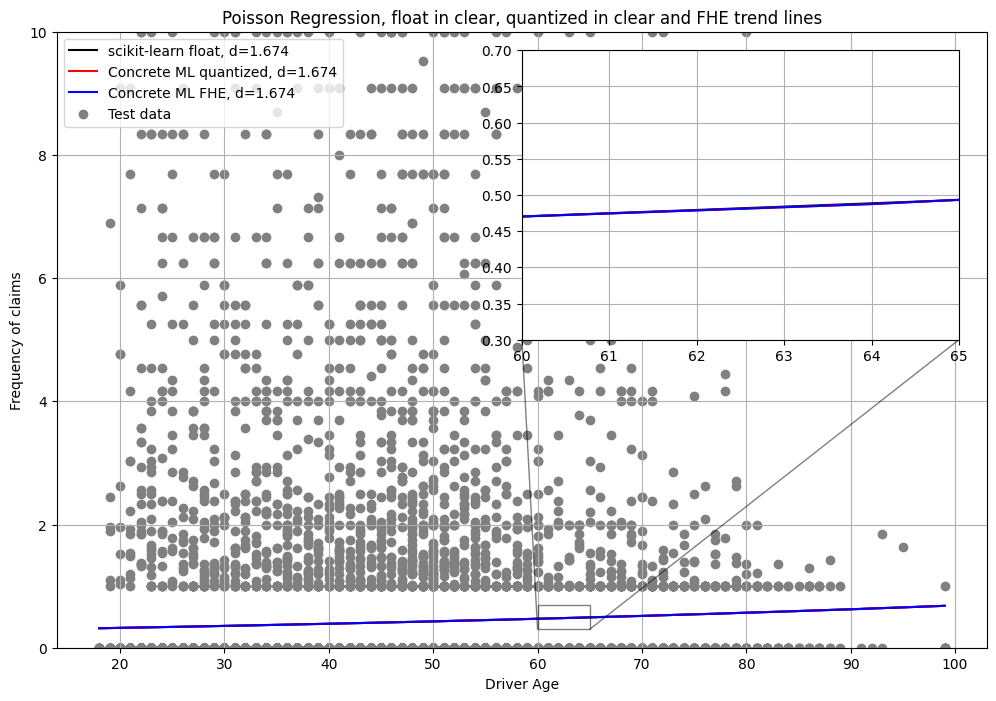

In [20]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")

# Plot the scikit-learn in clear model's main trend line
ax.plot(
    test_data,
    sklearn_predictions,
    color="black",
    label=f"scikit-learn float, d={sklearn_score:.3f}",
)

# Plot the Concrete quantized in clear model's main trend line
ax.plot(
    test_data,
    concrete_predictions,
    color="red",
    label=f"Concrete ML quantized, d={concrete_score:.3f}",
)

# Plot the Concrete FHE model's main trend line
ax.plot(
    test_data,
    concrete_predictions_fhe,
    color="blue",
    label=f"Concrete ML FHE, d={concrete_fhe_score:.3f}",
)

# Plot the test data
ax.scatter(df_test["DrivAge"], df_test["Frequency"], marker="o", color="gray", label="Test data")

# Parametrize the main figure
ax.set_xlabel("Driver Age")
ax.set_ylim(0, 10)
ax.set_title("Poisson Regression, float in clear, quantized in clear and FHE trend lines")
ax.set_ylabel("Frequency of claims")
ax.legend(loc="upper left")
ax.grid()

# Set a zoomed-in figure
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])

# Plot the scikit-learn in clear model's zoomed trend line
axins.plot(
    test_data,
    sklearn_predictions,
    color="black",
)

# Plot the Concrete FHE model's zoomed trend line
axins.plot(
    test_data,
    concrete_predictions,
    color="red",
)

# Plot the Concrete FHE model's zoomed trend line
axins.plot(
    test_data,
    concrete_predictions_fhe,
    color="blue",
)

# Parametrize the zoomed figure
x1, x2, y1, y2 = 60, 65, 0.3, 0.7
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid()
ax.indicate_inset_zoom(axins, edgecolor="black")

display(fig)

We can observe that all three trend lines (from the float, quantized and FHE models) seem identical !

## A multivariate model

The simple single-variable model does not achieve good results (age is not a good predictor by itself for the number of claims). Therefore, let's train a model with all of our predictor variables. 

In order to do so, we will need to apply some preprocessing methods to the data with the help of scikit-learn's Pipeline tool. Let's thus import the desired packages:

In [21]:
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

warnings.filterwarnings("ignore")

We first proceed by transforming the raw features into ones that can be given to a regression model. Thus, the categorical features are transformed using one-hot encoding while the resolution of vehicle and person ages is reduced using binning. Transforming the data this way, we end up with a total of 57 continuous features instead of the initial 11 ones.

In [22]:
log_scale_transformer = make_pipeline(FunctionTransformer(np.log, validate=False), StandardScaler())

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10), ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(sparse=False),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)

Let's now train a scikit-learn model and its equivalent FHE one using Concrete ML.

In [23]:
sklearn_pr = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", SklearnPoissonRegressor()),
    ]
)

n_bits = 16
concrete_pr = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", ConcretePoissonRegressor(n_bits=n_bits)),
    ]
)

sklearn_pr.fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

concrete_pr.fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]);

Now, let's evaluate the models:

In [24]:
def score_estimator(estimator, df_test, fhe="disable"):
    """Score an estimator on the test set."""

    if fhe == "execute":
        time_begin = time.time()
        y_pred = estimator.predict(df_test, fhe="execute")
        print(
            f"FHE execution time: {(time.time() - time_begin) / len(df_test):.4f} "
            "seconds per sample\n"
        )

    else:
        y_pred = estimator.predict(df_test)

    y_pred = np.squeeze(y_pred)
    y_true = df_test["Frequency"]
    sample_weight = df_test["Exposure"]

    # Ignore non-positive predictions, as they are invalid for the Tweedie deviance (except if
    # power is equal to 0, making the model equivalent to a Linear Regression). We want to
    # issue a warning if for some reason (e.g., low quantization, user error), the regressor
    # predictions are negative.

    # Find all strictly positive values
    mask = y_pred > 0

    # If any non-positive values are found, issue a warning
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f"for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    return mean_poisson_deviance(y_true[mask], y_pred[mask], sample_weight=sample_weight[mask])

In [25]:
sklearn_score = score_estimator(sklearn_pr, df_test)
concrete_score = score_estimator(concrete_pr, df_test)

print(f"scikit-learn (clear) deviance score: {sklearn_score:.4f}")
print(f"Concrete'ML (FHE) deviance score: {concrete_score:.4f}")

# Measure the error of the FHE quantized model with respect to the clear scikit-learn
# float model
score_difference = abs(concrete_score - sklearn_score) * 100 / sklearn_score
print(
    "Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores:",
    f"{score_difference:.2f}%\n",
)

scikit-learn (clear) deviance score: 1.5905
Concrete'ML (FHE) deviance score: 1.5905
Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores: 0.00%



We can observe that the deviance scores are identical (with an order of magnitude of about 1e-4).

### Test the multivariate GLM with multiple quantization bit widths for inputs

We now want to observe the impact of quantization over the models' performance. As for all linear 
models available in Concrete ML, a user has to set the `n_bits` parameter for initialization. This 
parameter can either be:
- a dictionary composed of `op_inputs` and `op_weights` keys. These parameters are given as 
    integers representing the number of bits over which the associated data should be quantized.

- an integer, representing the number of bits over which each input and weight should be quantized.
    Default is 8.
 
Thus, let's evaluate the influence of quantizing the inputs.

In [26]:
n_bits_values = list(range(2, 20))
concrete_deviance_scores = []
for n_bits in n_bits_values:
    concrete_regressor = Pipeline(
        [
            ("preprocessor", linear_model_preprocessor),
            ("regressor", ConcretePoissonRegressor(n_bits=n_bits)),
        ]
    )
    concrete_regressor.fit(
        df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
    )
    concrete_deviance_scores.append(score_estimator(concrete_regressor, df_test))

We then plot the Poisson deviance with respect to the quantized bit width in order to show how performance degrades with quantization:

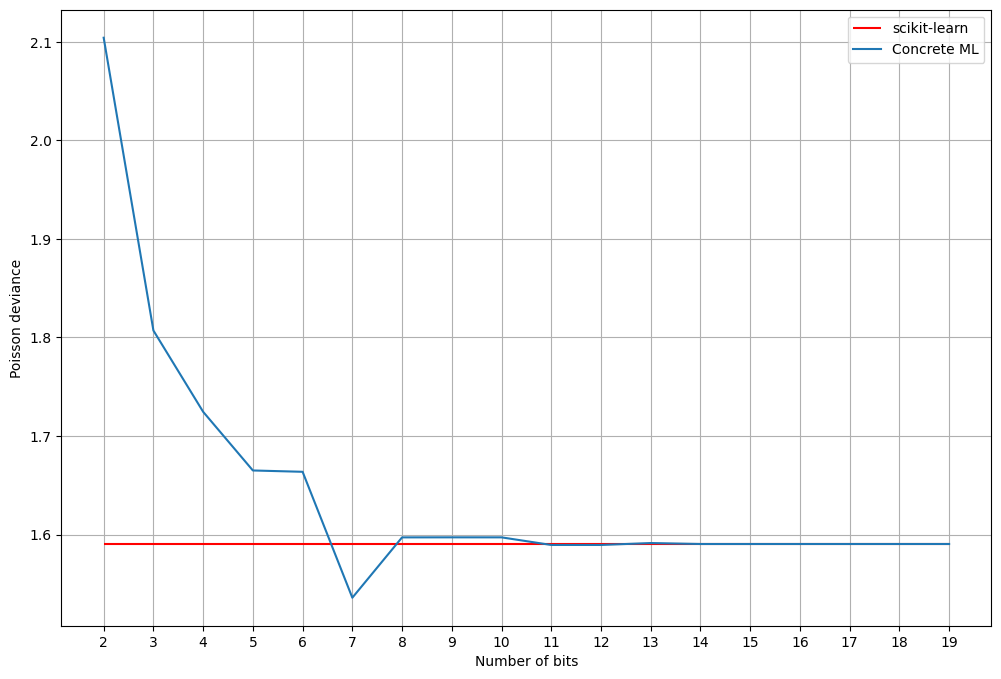

In [27]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.hlines(y=sklearn_score, xmax=2, xmin=19, color="r", label="scikit-learn")
ax.plot(n_bits_values, concrete_deviance_scores, label="Concrete ML")
ax.set_xlabel("Number of bits")
ax.set_ylabel("Poisson deviance")
ax.set_xticks(n_bits_values)
ax.set_xticklabels([str(k) for k in n_bits_values])
ax.grid()
ax.legend(loc="upper right")
display(fig)

### Analysis

We can observe that quantizing the inputs and weights with 6 bits or less decreases the 
model's performance. The deviance score then becomes mostly stable, until exactly matching the 
scikit-learn model's one. Besides, the slight score improvement seen with `n_bits=7` most probably
comes from some quantization artifacts that help the model generalize a bit more to the specific 
given test data-set.

### Compile the multivariate GLM to FHE. 

In [28]:
n_bits = 11

poisson_regressor_fhe = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", ConcretePoissonRegressor(n_bits=n_bits)),
    ]
)
poisson_regressor_fhe.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
);

Again, with a single line of code we compile to FHE:

In [29]:
# Compile needs some preprocessed data in order to run.
df_test_processed = poisson_regressor_fhe["preprocessor"].transform(df_test)

# pylint: disable-next=no-member
fhe_circuit = poisson_regressor_fhe["regressor"].compile(df_test_processed)

We then generate the key.

In [30]:
print(f"Generating a key for an {fhe_circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for an 26-bit circuit


In [31]:
time_begin = time.time()
fhe_circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.4f} seconds")

Key generation time: 0.0002 seconds


Finally, we evaluate the model on encrypted data. Be aware that running the FHE prediction can take a few seconds.

In [32]:
# Reducing the test set from 10000 to 1000 for faster FHE execution
df_test = df_test[:1000]

concrete_score_fhe = score_estimator(poisson_regressor_fhe, df_test, fhe="execute")

print(f"scikit-learn (clear) deviance score: {score_estimator(sklearn_pr, df_test):.4f}")
print(f"Concrete ML (FHE) deviance score: {concrete_score_fhe:.4f}")

# Measure the error of the FHE quantized model with respect to the clear scikit-learn
# float model
score_difference = abs(concrete_score - sklearn_score) * 100 / sklearn_score
print(
    "Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores:",
    f"{score_difference:.2f}%\n",
)

FHE execution time: 0.0073 seconds per sample

scikit-learn (clear) deviance score: 1.5934
Concrete ML (FHE) deviance score: 1.5925
Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores: 0.00%



We can observe that the deviance scores are almost identical (with an order of magnitude of about 1e-3).

## Conclusion

In this tutorial, we have discussed how we can use Concrete ML in order to compute a Poisson 
regression model in FHE with a few lines of code. Additionally, we have shown that quantization has 
a negligible impact on the performance, making the Concrete ML models reach a score identical to its
scikit-learn equivalent.